# Electricity price trends in Lithuania: 2020-2023

In [1]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde
from tabulate import tabulate
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from pygam import LinearGAM, s
from scipy.stats import ranksums
import warnings

Publicly available data on day-ahead NordPool electricity prices, external temperatures, and electricity consumption was collected and aggregated to a daily resolution. Temperature data was obtained [from meteo.lt via an API](https://github.com/uktukt/Python_Playground/blob/main/meteo_API.ipynb), and consumption data was sourced from Litgrid, covering the period from 2020 to 2023. The analysis focused on identifying correlations between electricity prices and external factors, examining the impact of temperature fluctuations and significant global events on price dynamics. 

In [2]:
file_path = "data/el_all_data.xlsx"

sheet_names = ["2020", "2021", "2022", "2023"]

dfs = pd.read_excel(file_path, sheet_name=sheet_names)

# Access each dataframe using the corresponding year as the key
df_2020 = dfs["2020"]
df_2021 = dfs["2021"]
df_2022 = dfs["2022"]
df_2023 = dfs["2023"]

## Exploratory data analysis

In [3]:
# Iterate over each dataframe in the dictionary
for year, df in dfs.items():
    # Print the year as a header
    print(f"Year: {year}")
    # Print info and shape of the dataframe
    print(df.info())
    print(f"Shape: {df.shape}")
    print("-----------------------------------")


Year: 2020
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         366 non-null    datetime64[ns]
 1   temp         366 non-null    float64       
 2   price        366 non-null    float64       
 3   consumption  366 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.6 KB
None
Shape: (366, 4)
-----------------------------------
Year: 2021
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         365 non-null    datetime64[ns]
 1   temp         365 non-null    float64       
 2   price        365 non-null    float64       
 3   consumption  365 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.5 KB
None


In [4]:
# Iterate over each dataframe in the dictionary
for year, df in dfs.items():
    # Print the year as a header
    print(f"Year: {year}")
    # Print the head of the dataframe
    print(df.head())
    print("-----------------------------------")

Year: 2020
        date      temp  price  consumption
0 2020-01-01  2.088889  27.74     28649.34
1 2020-01-02  3.827778  26.77     33622.55
2 2020-01-03  1.350000  24.01     35134.23
3 2020-01-04  2.600000  23.96     32627.39
4 2020-01-05  0.350000  33.06     32246.68
-----------------------------------
Year: 2021
        date      temp  price  consumption
0 2021-01-01 -1.433333  36.24    29477.788
1 2021-01-02 -1.416667  43.17    31444.907
2 2021-01-03 -0.816667  31.64    31855.047
3 2021-01-04 -1.194444  43.88    35826.556
4 2021-01-05  0.244444  47.29    36017.816
-----------------------------------
Year: 2022
        date      temp   price  consumption
0 2022-01-01  2.944444   82.50    31136.525
1 2022-01-02 -1.166667   57.76    34071.840
2 2022-01-03  3.688889   91.85    37282.602
3 2022-01-04  4.194444  146.32    37972.173
4 2022-01-05  2.350000  122.64    38219.288
-----------------------------------
Year: 2023
        date       temp   price  consumption
0 2023-01-01  10.033333

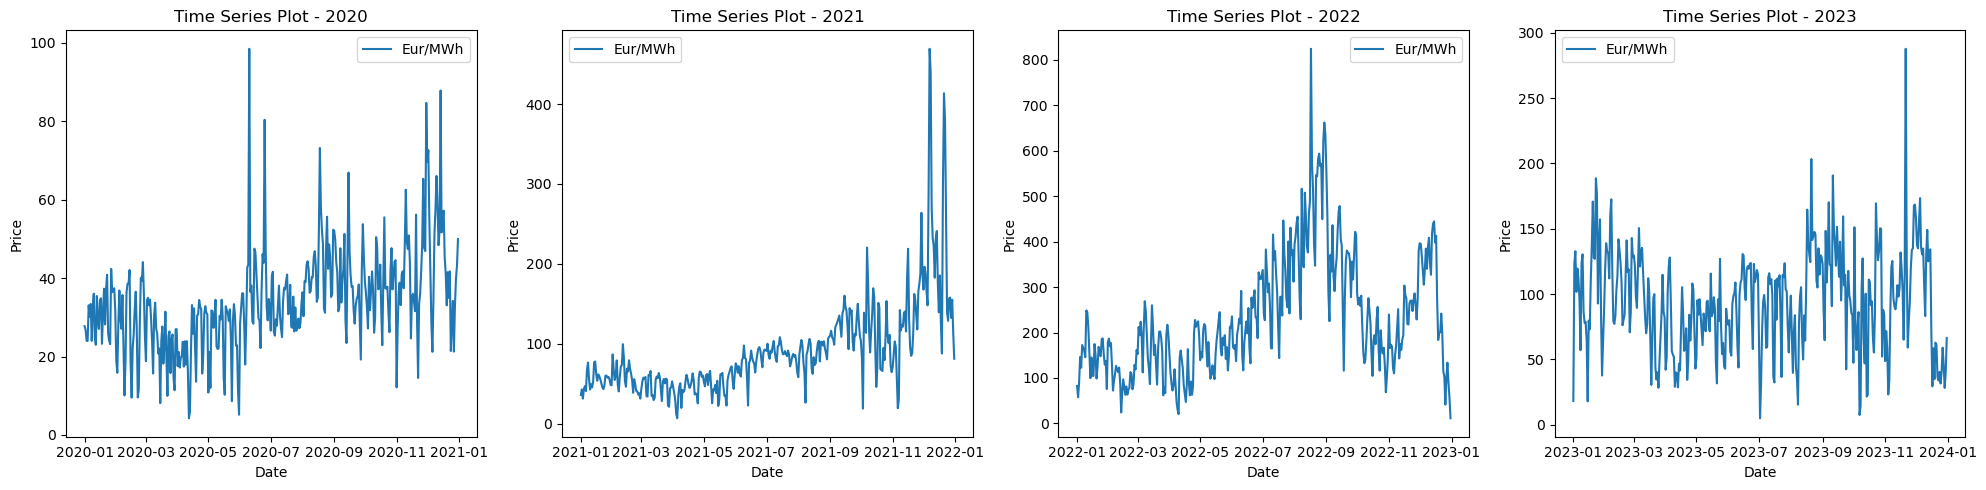

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, (year, df) in enumerate(dfs.items()):
    axes[i].plot(df['date'], df['price'], label='Eur/MWh')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')
    axes[i].set_title(f'Time Series Plot - {year}')
    axes[i].legend()

plt.tight_layout()
plt.show()


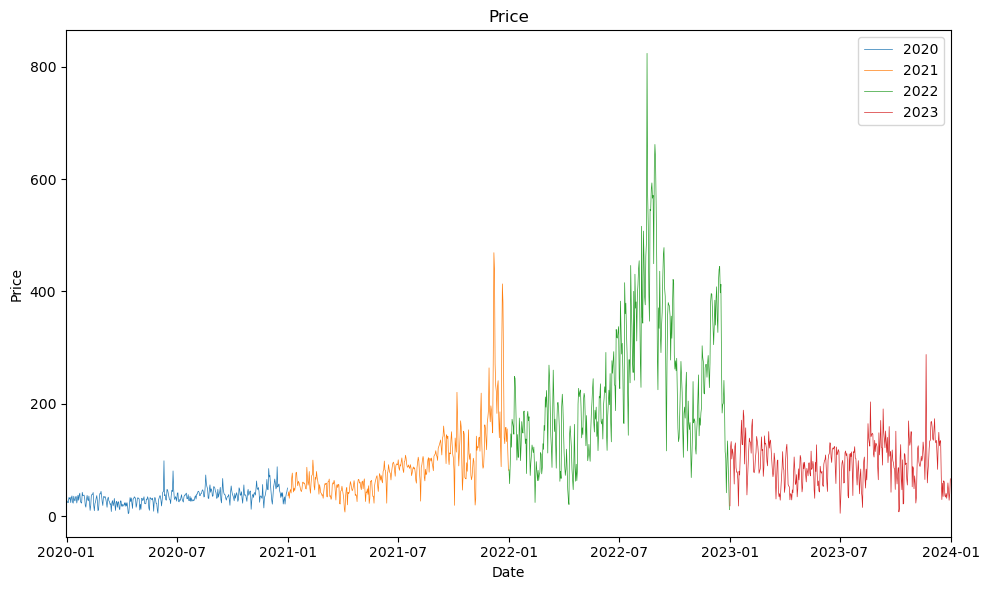

In [6]:
plt.figure(figsize=(10, 6))

# Plot time series
for year, df in dfs.items():
    plt.plot(df['date'], df['price'], label=f'{year}', linewidth=0.5)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price')
plt.legend()

# Set x-axis limits from 2020 to 2023
plt.xlim(pd.Timestamp('2019-12-31'), pd.Timestamp('2024-01-01'))

plt.tight_layout()

#plt.savefig('2020_2023_price.jpeg')
plt.show()

In each year, a short-term increase in prices is noticeable towards the end of the year. Additionally, the price increase in 2022 was influenced by geopolitical events. The average yearly price was 33.04 EUR/MWh for 2020, 90.45  EUR/MWh for 2021, 230.23 EUR/MWh for 2022, and 94.44 EUR/MWh for 2023.

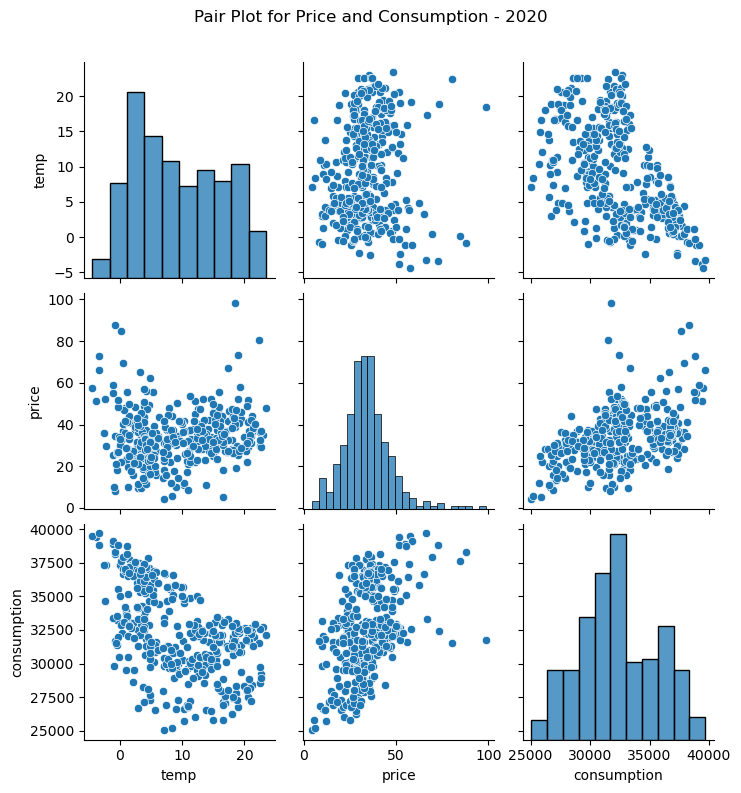

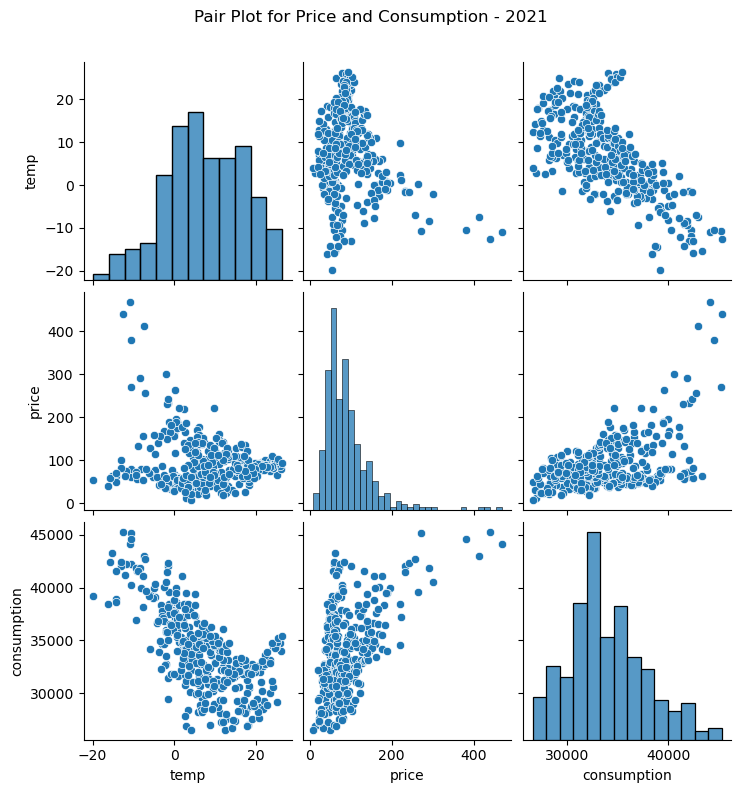

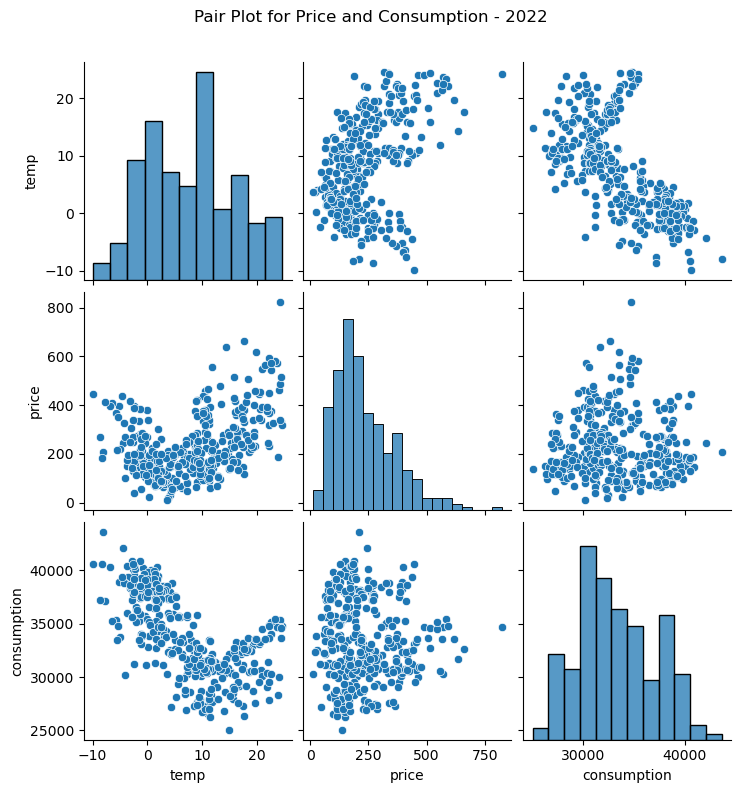

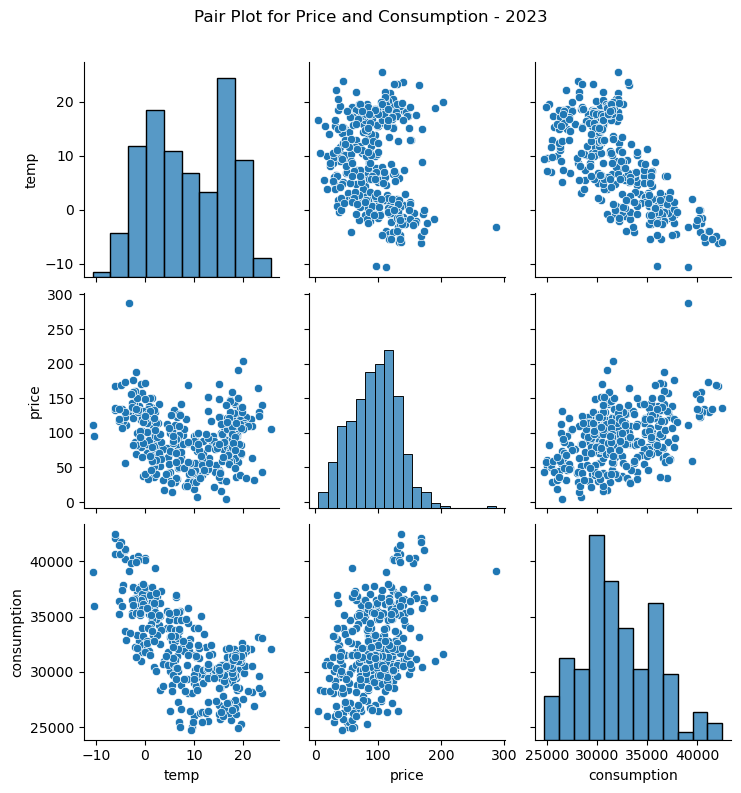

In [7]:
# Drop the "date" column from all dataframes
for df in dfs.values():
    df.drop(columns='date', inplace=False)

# Plot pair plots for "price" and "consumption" columns for all dataframes
for year, df in dfs.items():
    sns.pairplot(df[['temp', 'price', 'consumption']])
    plt.suptitle(f'Pair Plot for Price and Consumption - {year}', y=1.05)
    #plt.savefig(f'pair_plot_{year}.jpeg')
    plt.show()

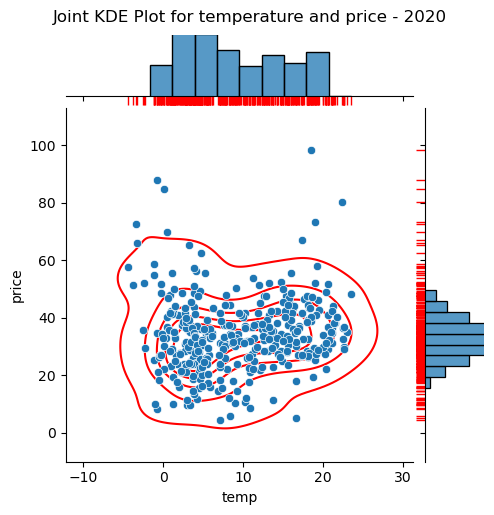

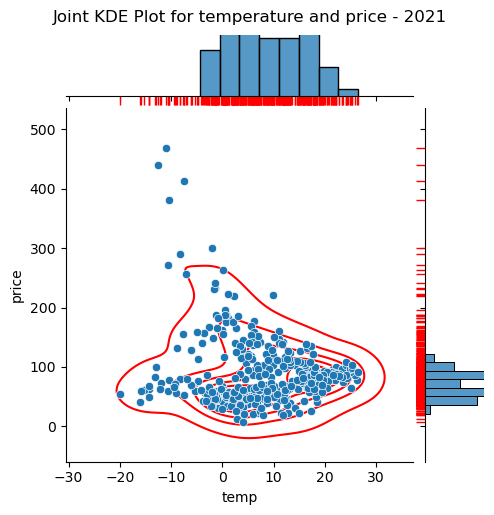

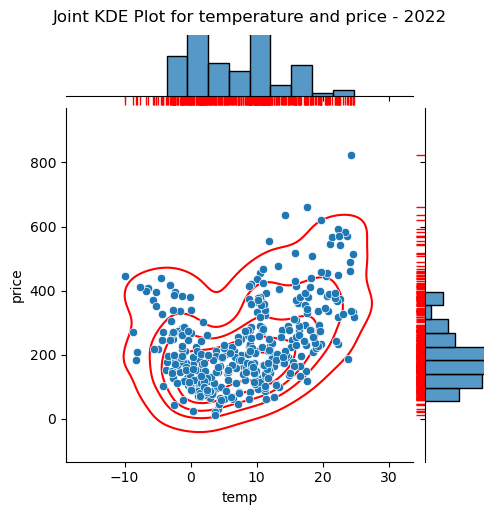

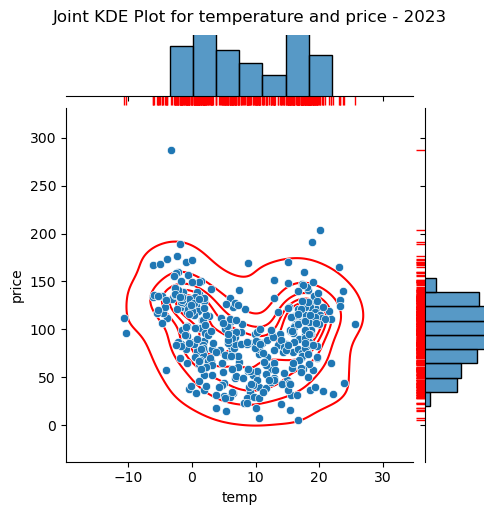

In [9]:
# Loop over all dataframes to create joint KDE plots
for year, df in dfs.items():
    # Create a joint KDE plot
    g = sns.jointplot(data=df, x='temp', y='price', height=5)
    g.plot_joint(sns.kdeplot, color='r', zorder=0, levels=6)
    g.plot_marginals(sns.rugplot, color='r', height=-.15, clip_on=False)
    g.fig.suptitle(f'Joint KDE Plot for temperature and price - {year}', y=1.02)
    #g.savefig(f'kde_{year}.jpeg')
    plt.show()

## Linear regression model 

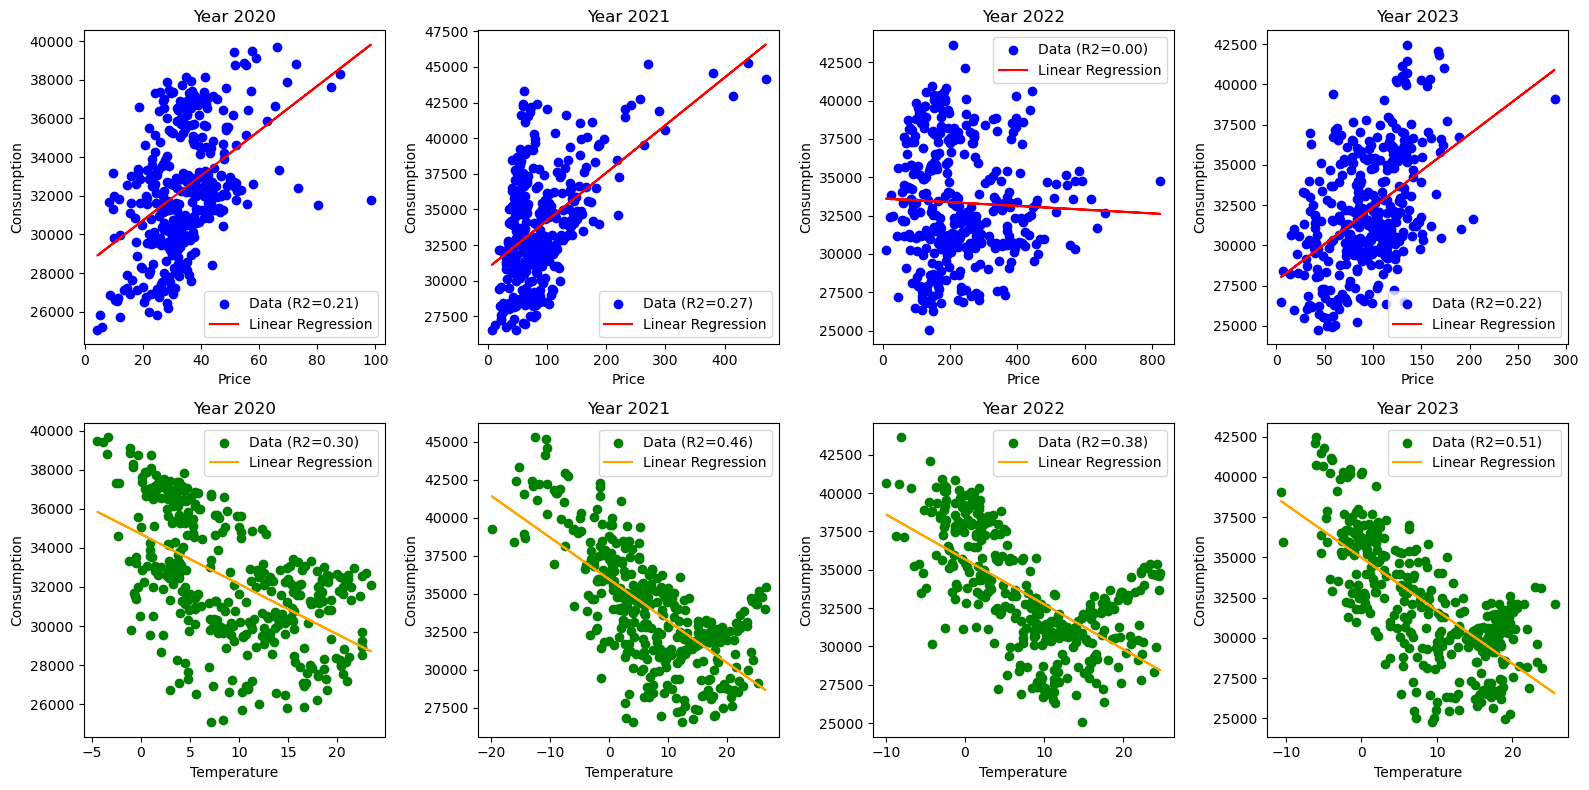

  Year    R2 (Price vs Consumption)    R2 (Temperature vs Consumption)
------  ---------------------------  ---------------------------------
  2020                   0.209795                             0.295408
  2021                   0.267448                             0.46039
  2022                   0.00174126                           0.383385
  2023                   0.220628                             0.508054


In [ ]:
# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

# Initialize a list to store R-squared values
r2_values = []

# Plot consumption vs price and consumption vs temperature for each year
for i, (year, df) in enumerate(zip(range(2020, 2024), dfs)):
    ax1 = axs[0, i]
    ax2 = axs[1, i]
    
    X_price = df[['price']]
    y_price = df['consumption']
    
    X_temp = df[['temp']]
    y_temp = df['consumption']
    
    # Linear regression for consumption vs price
    model_price = LinearRegression()
    model_price.fit(X_price, y_price)
    y_pred_price = model_price.predict(X_price)
    r2_price = r2_score(y_price, y_pred_price)
    
    # Linear regression for consumption vs temperature
    model_temp = LinearRegression()
    model_temp.fit(X_temp, y_temp)
    y_pred_temp = model_temp.predict(X_temp)
    r2_temp = r2_score(y_temp, y_pred_temp)
    
    # Append R-squared values to the list
    r2_values.append([year, r2_price, r2_temp])
    
    # Plot consumption vs price
    ax1.scatter(X_price, y_price, color='blue', label=f'Data (R2={r2_price:.2f})')
    ax1.plot(X_price, y_pred_price, color='red', label='Linear Regression')
    ax1.set_title(f'Year {year}')
    ax1.set_xlabel('Price')
    ax1.set_ylabel('Consumption')
    ax1.legend()
    
    # Plot consumption vs temperature
    ax2.scatter(X_temp, y_temp, color='green', label=f'Data (R2={r2_temp:.2f})')
    ax2.plot(X_temp, y_pred_temp, color='orange', label='Linear Regression')
    ax2.set_title(f'Year {year}')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel('Consumption')
    ax2.legend()

plt.tight_layout()
#plt.savefig('lin_reg_with_r2.jpeg')
plt.show()

# Print R-squared values
print(tabulate(r2_values, headers=["Year", "R2 (Price vs Consumption)", "R2 (Temperature vs Consumption)"]))


There is a clear linear dependence between consumption and price, where an increase in consumption correlates with a rise in price for the years 2020, 2021, and 2023. However, no such tendency is observed for the year 2022. For electricity consumption-temperature relationships, there is a tendency for consumption to increase when temperature decreases throughout the entire period investigated. The R-squared values for the linear and polynomal fit are presented in Table 1.  The R-squared value for the Consumption vs. Price linear fit in 2023 (0.221) is similar to that of the pre-war years in Ukraine, which were 0.267 in 2020 and 0.210 in 2021, respectively. While, for 2022, it is almost negligible at 0.002.

## Second-order polynomial model 

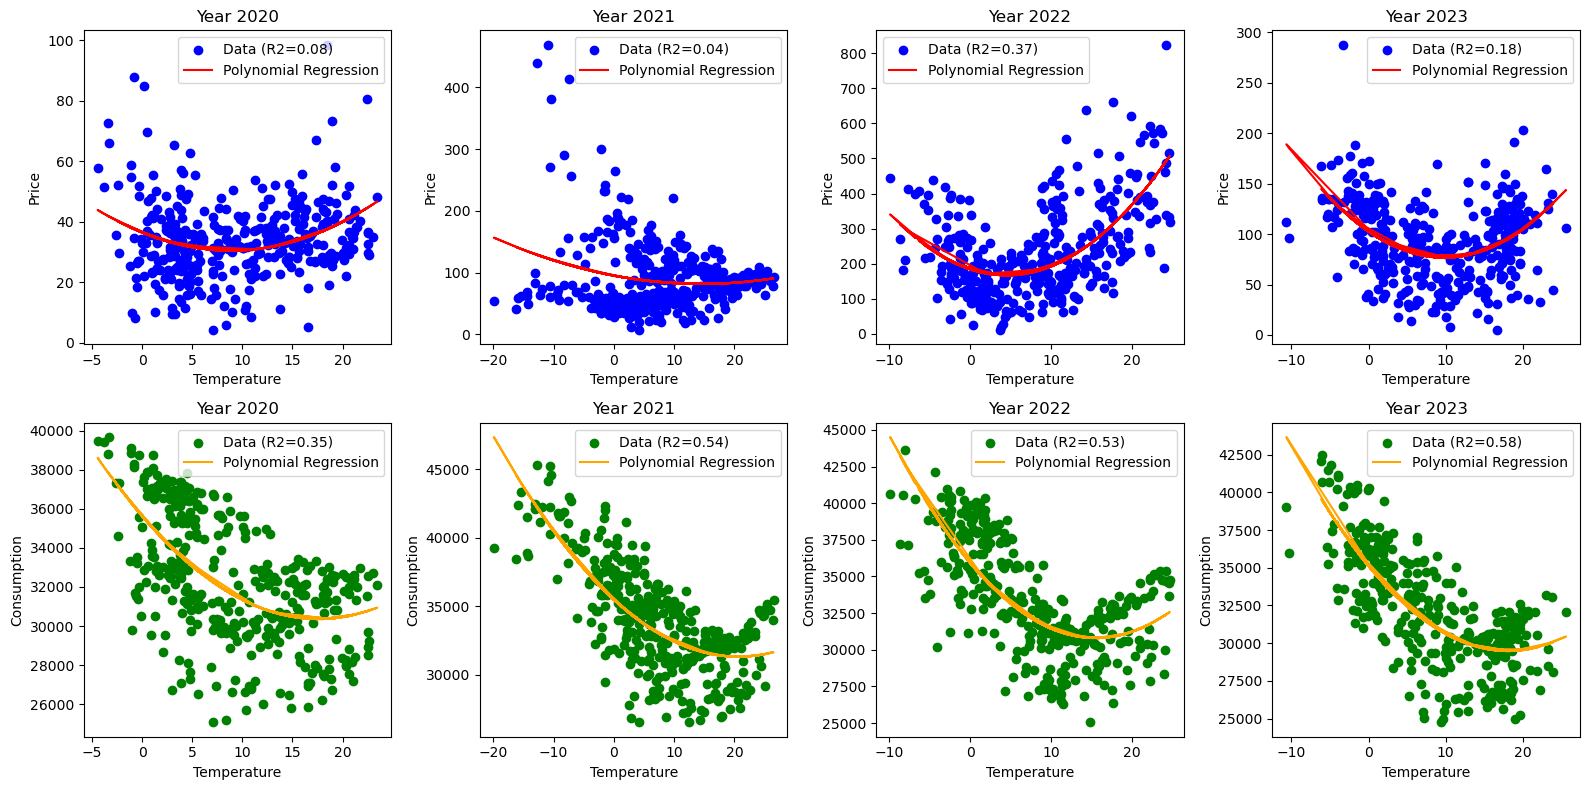

  Year    R2 (Price vs Temperature)    R2 (Consumption vs Temperature)
------  ---------------------------  ---------------------------------
  2020                    0.0751521                           0.346617
  2021                    0.0402233                           0.540865
  2022                    0.372119                            0.529901
  2023                    0.184567                            0.578814


In [ ]:
# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

# Initialize a list to store R-squared values
r2_values = []

# Plot consumption vs price and consumption vs temperature for each year
for i, (year, df) in enumerate(zip(range(2020, 2024), dfs)):
    ax1 = axs[0, i]
    ax2 = axs[1, i]
    
    X_price = df[['temp']]
    y_price = df['price']
    
    X_temp = df[['temp']]
    y_temp = df['consumption']
    
    # Fit polynomial regression for consumption vs price and consumption vs temperature
    model_price, model_temp = [make_pipeline(PolynomialFeatures(degree=2), LinearRegression()) for _ in range(2)]
    model_price.fit(X_price, y_price)
    model_temp.fit(X_temp, y_temp)
    
    # Predictions
    y_pred_price = model_price.predict(X_price)
    y_pred_temp = model_temp.predict(X_temp)
    
    # Calculate R-squared values
    r2_price = r2_score(y_price, y_pred_price)
    r2_temp = r2_score(y_temp, y_pred_temp)
    
    # Append R-squared values to the list
    r2_values.append([year, r2_price, r2_temp])
    
    # Plot consumption vs price
    ax1.scatter(X_price, y_price, color='blue', label=f'Data (R2={r2_price:.2f})')
    ax1.plot(X_price, y_pred_price, color='red', label='Polynomial Regression')
    ax1.set_title(f'Year {year}')
    ax1.set_xlabel('Temperature')
    ax1.set_ylabel('Price')
    ax1.legend()
    
    # Plot consumption vs temperature
    ax2.scatter(X_temp, y_temp, color='green', label=f'Data (R2={r2_temp:.2f})')
    ax2.plot(X_temp, y_pred_temp, color='orange', label='Polynomial Regression')
    ax2.set_title(f'Year {year}')
    ax2.set_xlabel('Temperature')
    ax2.set_ylabel('Consumption')
    ax2.legend()

plt.tight_layout()
#plt.savefig('poly_reg_with_r2.jpeg')
plt.show()

# Print R-squared values
print(tabulate(r2_values, headers=["Year", "R2 (Price vs Temperature)", "R2 (Consumption vs Temperature)"]))


The polynomial fit R-squared values indicate a more dominant polynomial tendency for the years 2022 and 2023, with values of 0.383 and 0.185 respectively. In contrast, for the years 2020 and 2021, the correlation was weaker, with R-squared values of 0.075 and 0.040 respectively. The polynomial fit appears to be more suitable for the Consumption vs. Temperature relationship compared to the linear fit, as evidenced by increasing R-squared values over the last four years: 2020 (0.347), 2021 (0.541), 2022 (0.530), and 2023 (0.579).

## Electricity prices on Weekdays and Weekends from 2020 to 2023

In [ ]:
# Define a function to identify weekdays and weekends
def get_day_category(date):
    if date.weekday() < 5:  # Monday (0) to Friday (4) are weekdays
        return 'Weekday'
    else:
        return 'Weekend'

# Apply the function to the date column in each DataFrame
for df_year in dfs:
    df_year['day_category'] = df_year['date'].apply(get_day_category)

# Separate data into DataFrames for weekdays and weekends for each year
for df_year in dfs:
    weekdays_df = df_year[df_year['day_category'] == 'Weekday']
    weekends_df = df_year[df_year['day_category'] == 'Weekend']

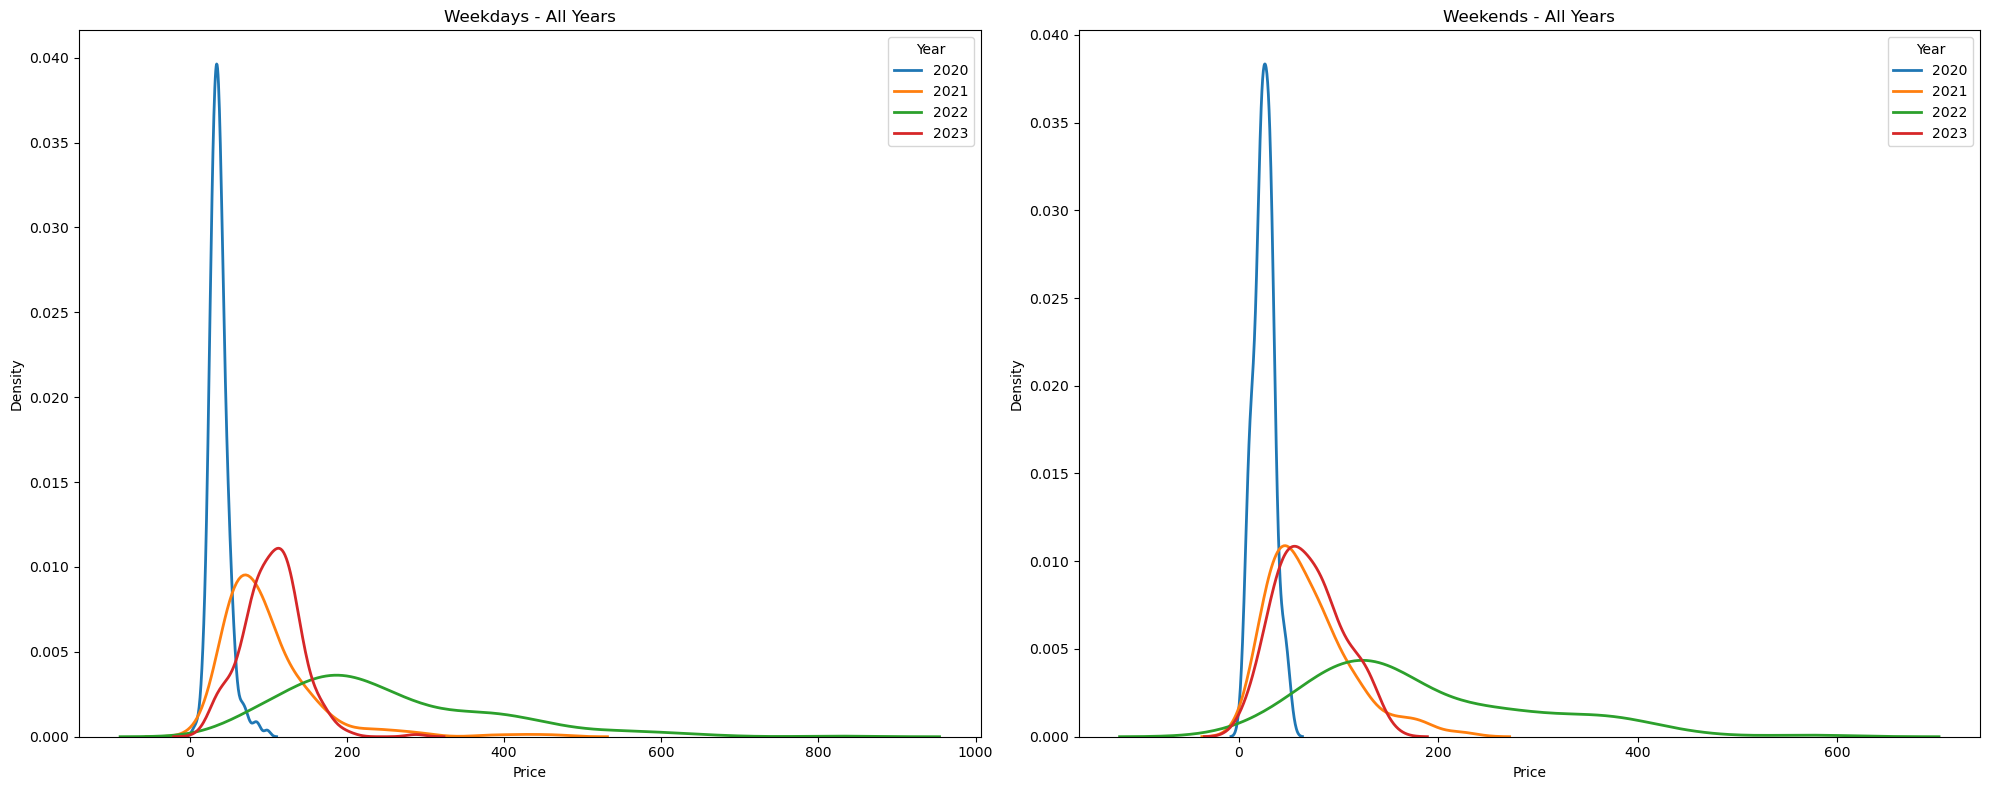

In [ ]:
# Create subplots for weekdays and weekends
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Loop over each year's DataFrames
for year in range(2020, 2024):
    # Get the index corresponding to the current year
    idx = year - 2020
    
    # Get weekdays and weekends DataFrames for the current year
    weekdays_df = dfs[idx][dfs[idx]['day_category'] == 'Weekday']
    weekends_df = dfs[idx][dfs[idx]['day_category'] == 'Weekend']
    
    # Calculate KDE with normalization for weekdays
    sns.kdeplot(data=weekdays_df['price'], label=f'{year}', ax=axes[0], common_norm=True, linewidth=2)
    axes[0].set_title(f'Weekdays - All Years')
    axes[0].set_xlabel('Price')
    axes[0].set_ylabel('Density')
    
    # Calculate KDE with normalization for weekends
    sns.kdeplot(data=weekends_df['price'], label=f'{year}', ax=axes[1], common_norm=True, linewidth=2)
    axes[1].set_title(f'Weekends - All Years')
    axes[1].set_xlabel('Price')
    axes[1].set_ylabel('Density')

# Add legends
axes[0].legend(title='Year', loc='upper right')
axes[1].legend(title='Year', loc='upper right')

# Adjust layout
plt.tight_layout()
#plt.savefig('kde_all.jpeg')
plt.show()

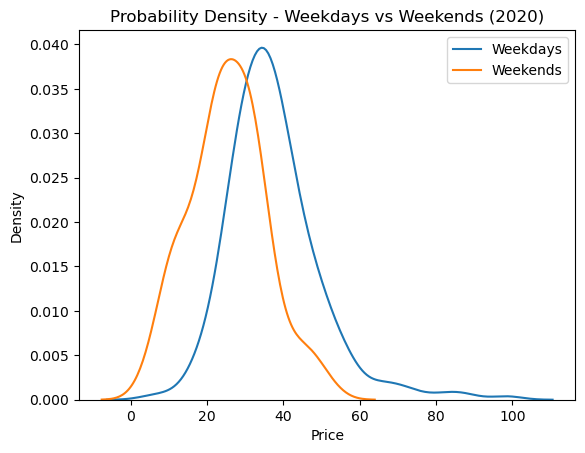

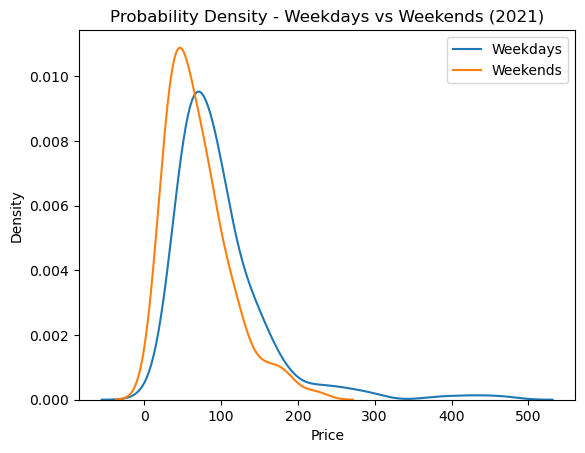

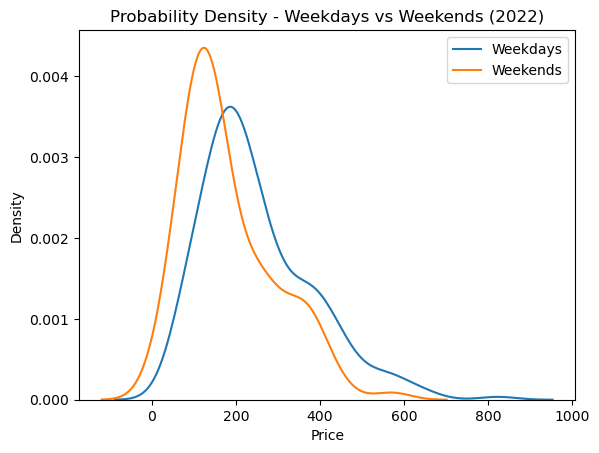

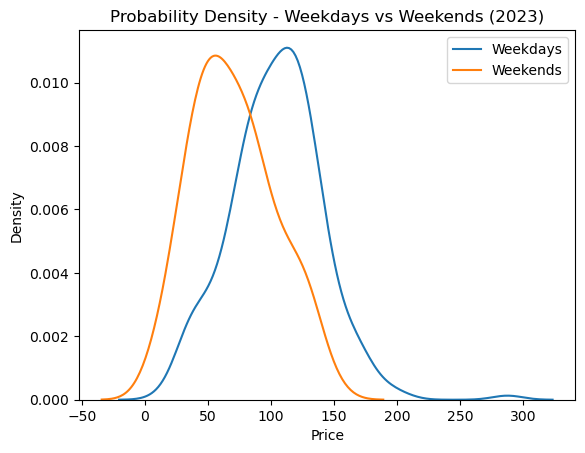

  Year    Weekdays - Max Density X    Weekends - Max Density X    Difference between max on Weekdays and Weekends
------  --------------------------  --------------------------  -------------------------------------------------
  2020                       34.42                       26.3                                                8.12
  2021                       71.02                       46.5                                               24.52
  2022                      186.56                      125.31                                              61.25
  2023                      112.84                       56.06                                              56.78


In [ ]:
# Initialize an empty list to store the results
results = []

# Loop over each year's DataFrames
for year in range(2020, 2024):
    # Get the index corresponding to the current year
    idx = year - 2020
    
    # Get weekdays and weekends DataFrames for the current year
    weekdays_df = dfs[idx][dfs[idx]['day_category'] == 'Weekday']
    weekends_df = dfs[idx][dfs[idx]['day_category'] == 'Weekend']
    
    # Compute KDE for weekdays and weekends
    weekdays_kde = gaussian_kde(weekdays_df['price'])
    weekends_kde = gaussian_kde(weekends_df['price'])
    
    # Find the x value where the density is maximum for weekdays
    weekdays_max_density_x = weekdays_df['price'].iloc[np.argmax(weekdays_kde.pdf(weekdays_df['price']))]
    
    # Find the x value where the density is maximum for weekends
    weekends_max_density_x = weekends_df['price'].iloc[np.argmax(weekends_kde.pdf(weekends_df['price']))]
    
    # Calculate the difference between maximum x values for weekdays and weekends
    max_diff = weekdays_max_density_x - weekends_max_density_x
    
    # Append the results for this year to the list
    results.append([year, weekdays_max_density_x, weekends_max_density_x, max_diff])

    # Create KDE plots for both weekdays and weekends
    sns.kdeplot(data=weekdays_df['price'], label='Weekdays')
    sns.kdeplot(data=weekends_df['price'], label='Weekends')
    plt.title(f'Probability Density - Weekdays vs Weekends ({year})')
    plt.xlabel('Price')
    plt.ylabel('Density')
    plt.legend()
    #plt.savefig(f'probability_density_{year}.jpeg')
    plt.show()

table = tabulate(results, headers=["Year", "Weekdays - Max Density X", "Weekends - Max Density X", "Difference between max on Weekdays and Weekends"])

print(table)


In [ ]:
# Initialize an empty list to store the p-values
p_values = []

# Loop over each year's DataFrames
for year in range(2020, 2024):
    # Get the index corresponding to the current year
    idx = year - 2020
    
    # Get weekdays and weekends DataFrames for the current year
    weekdays_df = dfs[idx][dfs[idx]['day_category'] == 'Weekday']
    weekends_df = dfs[idx][dfs[idx]['day_category'] == 'Weekend']
    
    # Perform Wilcoxon rank-sum test
    _, p_value = ranksums(weekdays_df['price'], weekends_df['price'])
    
    # Append the p-value for this year to the list
    p_values.append([year, p_value])

# Print the p-values
print(tabulate(p_values, headers=["Year", "p-value"]))

  Year      p-value
------  -----------
  2020  4.80773e-18
  2021  3.28813e-07
  2022  5.01411e-07
  2023  1.75482e-14


As expected, distributions for weekdays are shifted to higher prices compared to the distributions for weekends. Additionally, a tendency emerged where the difference between price values for peaks in distributions for weekdays and weekends became more pronounced even over the short period of 2020-2023.

The analysis involved calculating p-values to assess the distributions of electricity prices for weekdays and weekends. This was performed using the ranksums function from the scipy.stats library, which implements the Wilcoxon rank-sum test. Unlike parametric tests like the two-sample t-test, the Wilcoxon rank-sum test examines the ranks of data points rather than their raw values. This approach is advantageous as it does not rely on assumptions about the underlying distribution of the data, such as normality, making it a robust non-parametric method for comparing distributions. 

These p-values indicate strong evidence against the null hypothesis, suggesting significant differences in price distributions between weekdays and weekends across all four years.

## Generalized additive models

Year: 2020
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.0533
Link Function:                     IdentityLink Log Likelihood:                                 -2168.0531
Number of Samples:                          366 AIC:                                              4362.213
                                                AICc:                                            4363.2554
                                                GCV:                                              157.9642
                                                Scale:                                            148.6286
                                                Pseudo R-Squared:                                   0.1246
Feature Function          

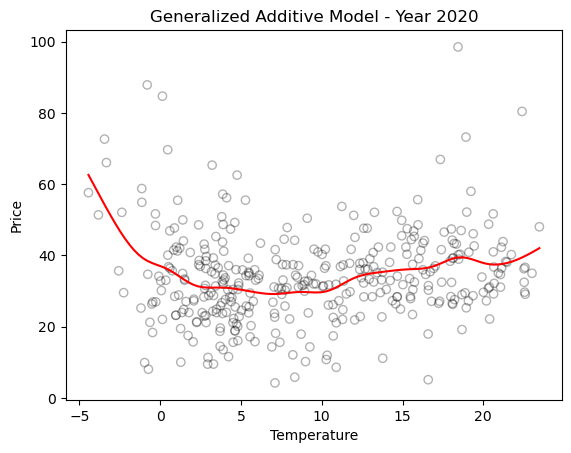

Year: 2021
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.8399
Link Function:                     IdentityLink Log Likelihood:                                  -3278.546
Number of Samples:                          365 AIC:                                             6582.7717
                                                AICc:                                            6583.7838
                                                GCV:                                             3371.8083
                                                Scale:                                           3175.5205
                                                Pseudo R-Squared:                                   0.1262
Feature Function          

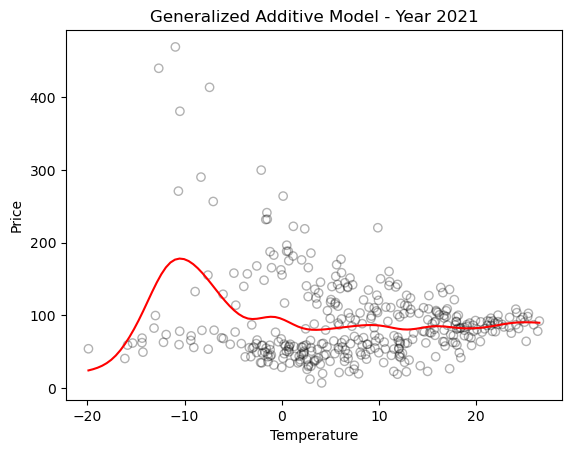

Year: 2022
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.0513
Link Function:                     IdentityLink Log Likelihood:                                 -3693.3884
Number of Samples:                          365 AIC:                                             7412.8794
                                                AICc:                                            7413.9245
                                                GCV:                                            10519.2632
                                                Scale:                                           9895.9915
                                                Pseudo R-Squared:                                   0.4287
Feature Function          

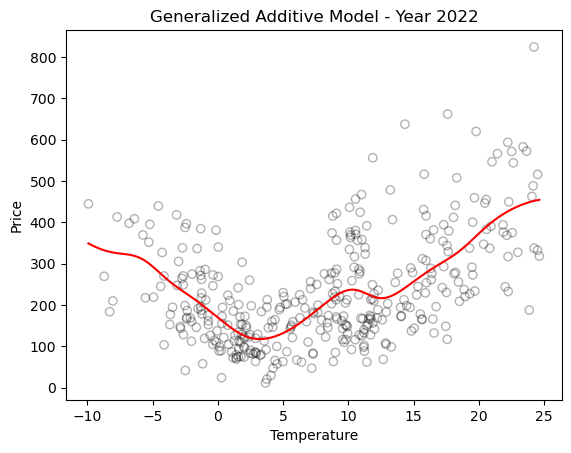

Year: 2023
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      11.628
Link Function:                     IdentityLink Log Likelihood:                                  -2902.255
Number of Samples:                          365 AIC:                                             5829.7658
                                                AICc:                                            5830.7454
                                                GCV:                                             1200.9794
                                                Scale:                                           1132.3126
                                                Pseudo R-Squared:                                   0.2629
Feature Function          

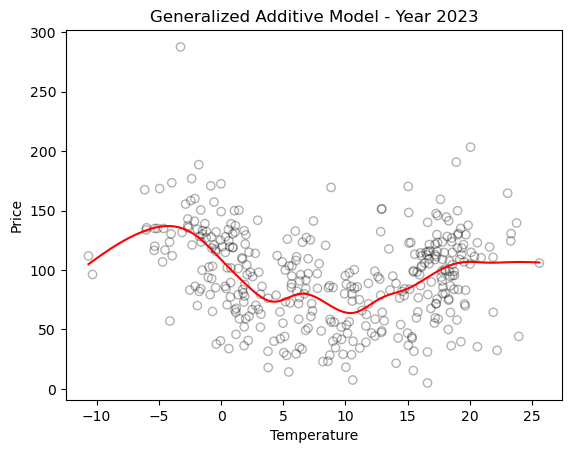

  Year    Deviance Explained (R-squared)
------  --------------------------------
  2020                          0.124628
  2021                          0.126153
  2022                          0.428698
  2023                          0.262942


In [ ]:
# Initialize an empty list to store the results
results = []

# Iterate over each year's DataFrame assuming the years start from 2020
for idx, df in enumerate(dfs, start=2020):
    # Fit a GAM using formula interface
    gam = LinearGAM(s(0)).fit(df[['temp']], df['price'])

    # Calculate deviance explained (R-squared)
    residuals = df['price'] - gam.predict(df[['temp']])
    dev_exp = 1 - (residuals.var() / df['price'].var())

    # Append results
    results.append([idx, dev_exp])

    # Print summary of the model without warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(f"Year: {idx}")
        print(gam.summary())  # Omit verbosity argument

    # Plot the GAM
    plt.figure()
    XX = gam.generate_X_grid(term=0)
    plt.scatter(df['temp'], df['price'], facecolor='None', edgecolor='k', alpha=0.3)
    plt.plot(XX[:, 0], gam.predict(XX), color='r')
    plt.title(f'Generalized Additive Model - Year {idx}')
    plt.xlabel('Temperature')
    plt.ylabel('Price')
    plt.show()

# Print the deviance explained (R-squared) values in a tabular format
print(tabulate(results, headers=["Year", "Deviance Explained (R-squared)"]))

Generalized Additive Models (GAMs) faced the significant challenge of overfitting.

# Summary

The study reveals that electricity prices exhibit a parabolic pattern in response to changes in outside temperatures, with significant disruptions observed during major world events, such as the full-scale invasion of Ukraine in 2022. These disruptions led to sudden and unpredictable spikes in electricity prices, contrasting with the more predictable trends seen in previous years.
Analysis of the electricity consumption-price and consumption-temperature relationships indicates a clear linear dependence between consumption and price, with an increase in consumption correlating with a rise in price for most years, except for 2022. Additionally, a hyperbolic dependence is observed between temperature and electricity price, as well as temperature and consumption, highlighting the complex interplay between these factors.
Furthermore, probability density distributions of electricity prices reveal differences between weekdays and weekends, with prices on weekdays generally higher than those on weekends. This trend becomes more pronounced over the study period, indicating evolving consumer behavior and market dynamics.
Lastly, the study employs the Wilcoxon rank-sum test to assess the distributions of electricity prices for weekdays and weekends, providing further evidence of significant differences in price distributions across all four years.
